# GTA HS20 - Übung 12: Analyse von Bewegungsdaten 2

## Ziel der Übung

Das Ziel dieser Übung ist es, Bewegungsdaten mit Kontext zu erweitern. Mithilfe dieses Kontexts können zusätzliche Aussagen über Mobilität gemacht werden (z.B. warum oder wie jemand reist). Wir werden insbesondere die folgenden Aspekte betrachten: 

- __Teil 1:__ Extraktion von Points of Interest (POI) um Haltepunkte und Trajektorien herum.
- __Teil 2:__ Nutzung der Strassendaten um die Qualität der Daten zu verbessern (Map Matching).

## Vorgehen

### 1) Vorüberlegung: Was sind relevante Kontextdaten von Mobilität?
In den letzten Übungen haben wir bereits verschiedene Aspekte von Mobilität beleuchtet. Heute wollen wir Bewegungsdaten im Kontext in dem sie unweigerlich stattfinden betrachten.

Überlegen sie sich welche Kontextfaktoren interessant sein könnten, weil sie z.B. Mobilität beeinflussen oder uns erlauben zusätzliche Schlüsse zu ziehen.

* Wie wählen wir die Orte zu denen wir reisen?
* Was beeinflusst unsere Transportmittelwahl? 
* Welche Rückschlüsse können wir mit raum-zeitlichem Kontext auf Verkehrsmittel und Aktivitäten ziehen?

### 2) Übersicht über Funktionen und das Programm bekommen
Hier eine kurze Übersicht über die Funktionen, die wir in dieser Übung erstellen oder ihnen zur Verfügung stellen:
- `read_romataxidata()`: Die Daten werden aus der `.csv`-Datei in eine Liste `[X, Y, T]` (x-Koordinate, y-Koordinate, Zeitstempel) eingelesen.
- `transform()`: Transformiert die Taxidaten in ein Meter-Koordinatensystem und die Zeitstempel in Sekunden.
- `apply_dbscan()`: Wendet DBSCAN auf die Taxidaten an, um Haltepunkte zu extrahieren.
- `get_ipyleaflet_trackpoint_layer()`: Erstellt einen `ipyleaflet` Layer aus GPS-Fixes, welcher auf eine interaktive Karte gezeichnet werden kann.
- `df.plot()`: Plottet ein GeoDataFrame als Karte (ohne Basemap).
- `df.hist()`: Plottet ein Histogramm eines DataFrames.

Die Orte, an denen sie Code verändern müssen sind mit `TODO` gekennzeichnet.

Import und Definitionen:
Die folgenden zwei Codeblöcke importieren die verwendeten Bibliotheken und initialisieren Elemente die für die interaktive Darstellung der Triplegs benötigt werden. Durch klicken auf `Toggle show/hide` kann dieser Teil ausgeblendet werden.

In [1]:
import os
import time

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pygeos
import pyrosm
from pyrosm import OSM
import shapely
from shapely import wkt
from shapely.geometry import Polygon

from ipywidgets import HTML
import ipyleaflet as ipy
from ipyleaflet import WidgetControl

from analyse_von_bewegungsdaten_functions import pygeos_geometry_to_shapely

Die nachfolgend benutzten OSM Daten wurden via https://extract.bbbike.org heruntergeladen. Für grössere Regionen können sie aber z.B. auch via https://download.geofabrik.de heruntergeladen werden. Die Daten stehen in verschiedenen Formaten zur Verfügung. Das `.pbf` Format ist sehr kompakt und für OSM Daten optimiert, weshalb wir es hier verwenden. Dateien in diesem Format können jedoch nicht einfach "als Text" angeschaut werden (im Gegensatz zu https://geojson.org z.B.).

Wir benutzen die Bibliothek `pyrosm` um die `.pbf`-Datei zu lesen und bestimmte Subsets der Daten als GeoDataFrame zu extrahieren. `pyrosm` ist in Verion 0.5.3 verfügbar - oft werden Bibliotheken ab Version 1.0 als _stabil_ betrachtet. Dementsprechend müssen wir teils mit eigenen Funktionen ein bisschen nachhelfen und es kann auch zu verschiedenen Warnungen kommen. Als erstes erstellen wir ein `OSM`-Objekt.

In [2]:
osm = OSM('input_data/rome.osm.pbf')

Wir können dann z.B. auf alle Gebäude im extrahierten Bereich zugreifen und diese darstellen.

e:\data\teaching\20hs gta\pyrosm\pyrosm\pyrosm\buildings.py:38: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf = prepare_geodataframe(nodes, node_coordinates, ways,


<AxesSubplot:>

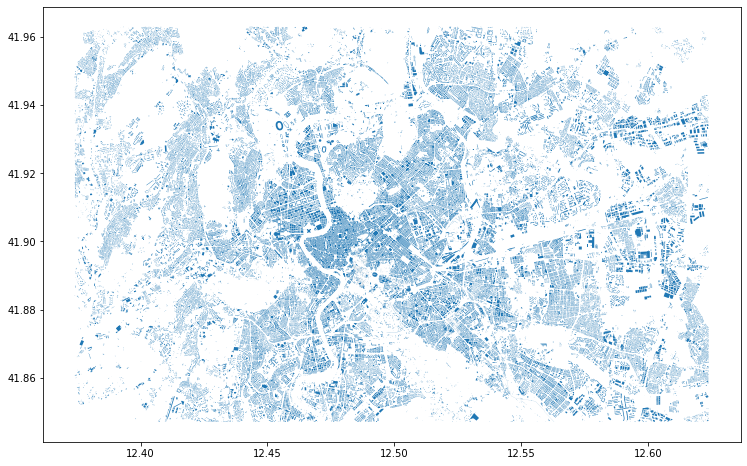

In [3]:
buildings = osm.get_buildings()
buildings['geometry'] = buildings.apply(lambda r: pygeos_geometry_to_shapely(r.geometry), axis=1)
buildings = buildings.set_geometry('geometry')
buildings.plot(figsize=(16, 8))

Wir können natürlich auch einzelne Gebäude und deren Attribute (wie auf OpenStreetMap gespeichert) anschauen:

In [4]:
buildings.head(3)

,addr:city,addr:country,addr:housenumber,addr:housename,addr:postcode,addr:street,email,name,opening_hours,operator,...,source,start_date,wikipedia,id,timestamp,version,tags,osm_type,geometry,changeset
0,None,None,None,None,None,None,sspsae-rm.castelsantangelo@beniculturali.it,Castel Sant’Angelo,Mo-Su 09:00-19:30,None,...,Bing Aerial,None,it:Castel Sant'Angelo,8035487,0,-1,"{""fee"":""yes"",""charge"":""14 EUR"",""name:cs"":""And\...",way,"POLYGON ((12.46600 41.90263, 12.46639 41.90264...",NaN
1,None,None,None,None,None,None,None,Mercato Talenti,None,None,...,None,None,None,23035987,0,-1,"{""description"":""mercato coperto""}",way,"POLYGON ((12.54250 41.94704, 12.54321 41.94779...",NaN
2,None,None,None,None,None,None,None,Stazione Termini,None,None,...,None,None,None,23276945,0,-1,None,way,"POLYGON ((12.50942 41.89748, 12.50922 41.89764...",NaN


Im ersten Schritt wollen wir jetzt aber Points of Interest extrahieren und mit den Bewegungsdaten verknüpfen.

### 3) POI aus OSM extrahieren und mit Haltepunkten verknüpfen

Wir kümmern uns zuerst einmal um die Haltepunkte.

In [5]:
custom_filter = {'amenity': True, "shop": True}
pois = osm.get_pois(custom_filter=custom_filter)
pois['geometry'] = pois.apply(lambda r: pygeos_geometry_to_shapely(r.geometry), axis=1)
pois = pois.set_geometry('geometry')

e:\data\teaching\20hs gta\pyrosm\pyrosm\pyrosm\pois.py:30: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf = prepare_geodataframe(nodes, node_coordinates, ways,


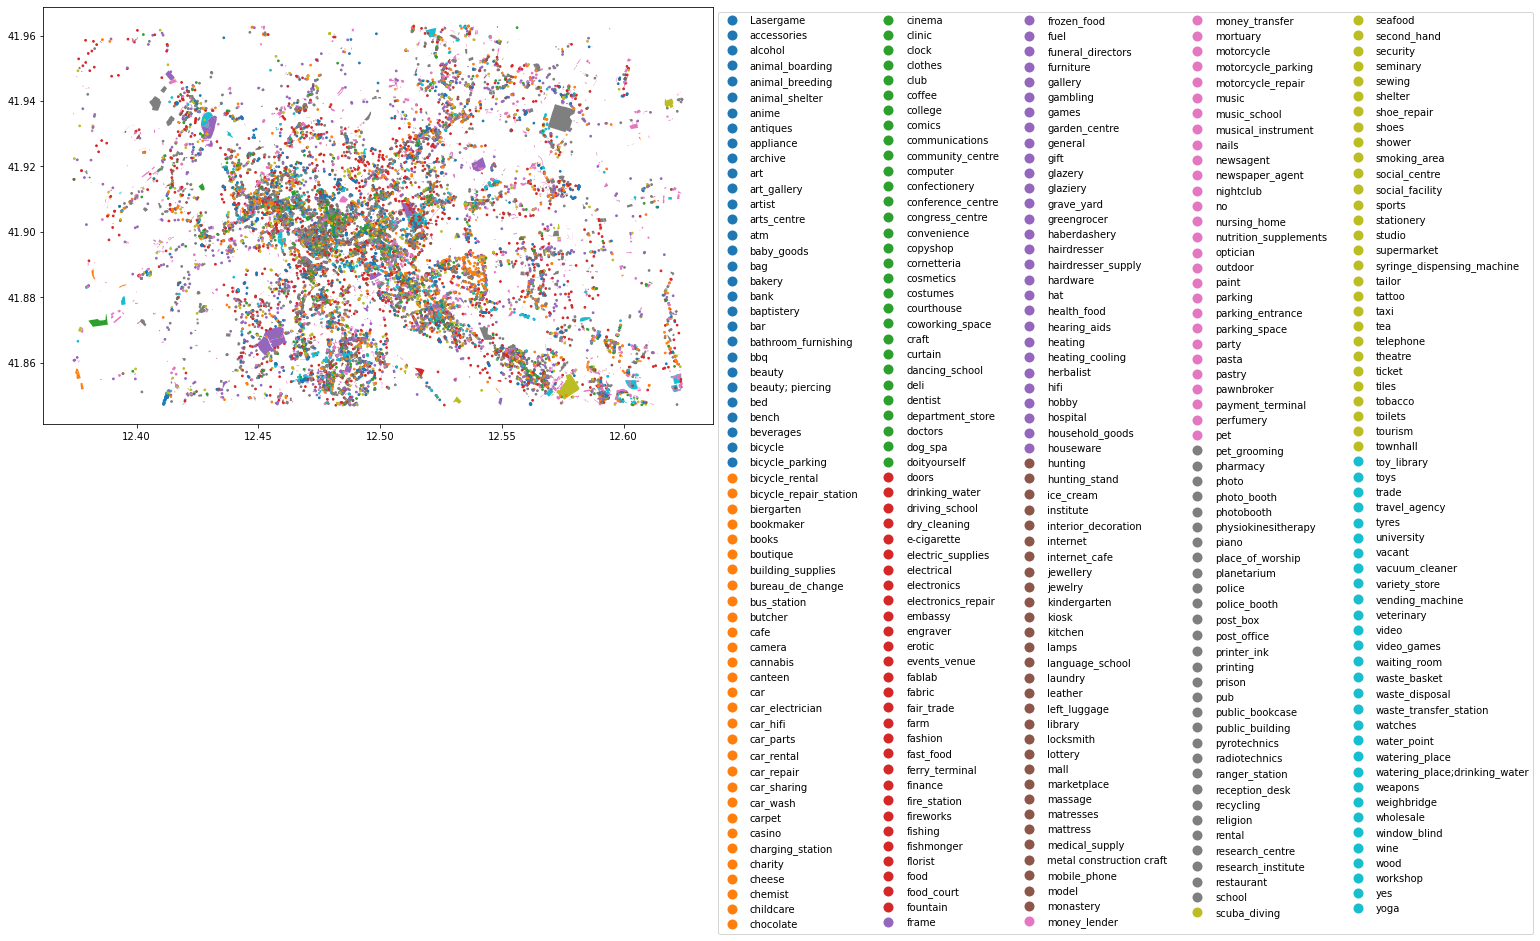

In [6]:
# Gather info about POI type (combines the tag info from "amenity" and "shop")
pois["poi_type"] = pois["amenity"]
pois["poi_type"] = pois["poi_type"].fillna(pois["shop"])

# Plot
ax = pois.plot(column='poi_type', markersize=3, figsize=(12,12), legend=True, 
               legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))

In [7]:
pois.head(3)

,id,tags,lat,timestamp,changeset,version,lon,addr:city,addr:country,addr:full,...,supermarket,tobacco,trade,geometry,osm_type,biergarten,building:levels,landuse,water,poi_type
0,32631124,"{""fax"":""+39 06 69941758"",""cuisine"":""ice_cream""...",41.901058,0,0.0,0,12.477248,Roma,IT,None,...,None,None,None,POINT (12.47725 41.90106),node,NaN,NaN,NaN,NaN,cafe
1,226903483,"{""brand"":""Api-Ip"",""ref:mise"":""14364""}",41.909256,0,0.0,0,12.417657,None,None,None,...,None,None,None,POINT (12.41766 41.90926),node,NaN,NaN,NaN,NaN,fuel
2,226903493,"{""brand"":""IP"",""ref:mise"":""39322""}",41.861176,0,0.0,0,12.533271,None,None,None,...,None,None,None,POINT (12.53327 41.86118),node,NaN,NaN,NaN,NaN,fuel


<AxesSubplot:>

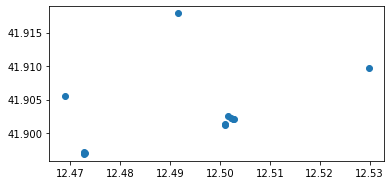

In [8]:
staypoints = pd.read_csv('input_data/staypoints.csv')
staypoints['geometry'] = staypoints['geometry'].apply(wkt.loads)
staypoints = gpd.GeoDataFrame(staypoints, crs='epsg:4326')

staypoints.plot()

### 4) POI aus OSM extrahieren und mit Triplegs verknüpfen

Schauen wir uns nun die Triplegs an.

<AxesSubplot:>

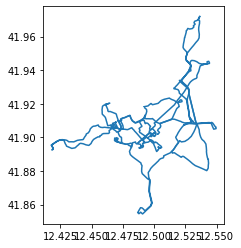

In [9]:
triplegs = pd.read_csv('input_data/triplegs.csv')
triplegs['geometry'] = triplegs['geometry'].apply(wkt.loads)
triplegs = gpd.GeoDataFrame(triplegs, crs='epsg:4326')

triplegs.plot()

### 5) Strassentypen aus OSM extrahieren und mit Triplegs verknüpfen

Nun wollen wir noch untersuchen entlang welcher Strassen die Taxis gefahren sind, und ob es Korrelationen mit der Geschwindigkeit gibt.

<AxesSubplot:>

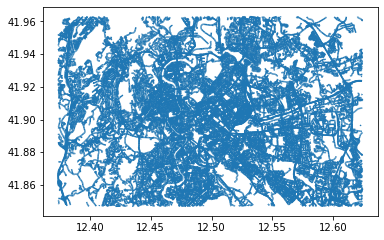

In [10]:
drive_net = osm.get_network(network_type="driving")
drive_net.plot()